# Demo `simulate` Module Features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as cas

from simulate import (
    ConstantInput,
    ForwardEuler,
    RungeKutta4,
    SimulationConfig,
    SimulationEngine,
    SinusoidalInput,
    StepInput,
    CasADiIntegrator
)

## Simple Pendulum Example

In [2]:
# Define pendulum dynamics
def pendulum_dynamics(t, x, u, p):
    theta, omega = x
    g = p["g"]
    L = p["L"]
    tau = u.get("torque", 0.0)

    dtheta = omega
    domega = -g / L * np.sin(theta) + tau / (p.get("m", 1.0) * L**2)

    return np.array([dtheta, domega])

# Create integrator and engine
integrator = RungeKutta4(pendulum_dynamics)
engine = SimulationEngine(integrator)

# Configure simulation
config = SimulationConfig(
    t_span=(0.0, 5.0),
    x0=np.array([np.pi / 4, 0.0]),
    inputs={"torque": ConstantInput(0.0)},
    parameters={"g": 9.81, "L": 1.0, "m": 1.0},
    dt=0.01,
)

# Run simulation
result = engine.simulate(config)

In [3]:
result

SimulationResult(n_steps=501, n_states=2, n_outputs=2, n_inputs=1)

In [4]:
help(result)

Help on SimulationResult in module simulate.results object:

class SimulationResult(builtins.object)
 |  SimulationResult(
 |      time: numpy.ndarray,
 |      states: Optional[pandas.core.frame.DataFrame] = None,
 |      outputs: Optional[pandas.core.frame.DataFrame] = None,
 |      inputs: Optional[pandas.core.frame.DataFrame] = None,
 |      config: Optional[Any] = None
 |  ) -> None
 |
 |  Container for simulation results.
 |
 |  Stores time series data from simulation including states, outputs,
 |  and inputs as pandas DataFrames with time as the index.
 |
 |  Parameters
 |  ----------
 |  time : ndarray
 |      Time points, shape (n_steps,)
 |  states : DataFrame, optional
 |      State trajectories with time index, shape (n_steps, n_states)
 |  outputs : DataFrame, optional
 |      Output trajectories with time index, shape (n_steps, n_outputs)
 |  inputs : DataFrame, optional
 |      Input trajectories with time index, shape (n_steps, n_inputs)
 |  config : SimulationConfig, op

In [5]:
result.inputs["torque"].shape

(501,)

In [6]:
def make_time_series_plots(signals, xlabel="Time", ylabel=None, title_fmt="Signal: {name}", figsize=None):

    n = signals.shape[1]
    if figsize is None:
        figsize = (7, 1 + 1.5 * n)

    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(7, 1 + 1.5 * n))
    if n == 1:
        axes = [axes]

    for ax, name in zip(axes, signals):
        ax.plot(signals.index, signals[name])
        ax.set_ylabel(ylabel)
        ax.grid()
        ax.set_title(title_fmt.format(name=name))

    axes[-1].set_xlabel(xlabel)

    return fig, axes

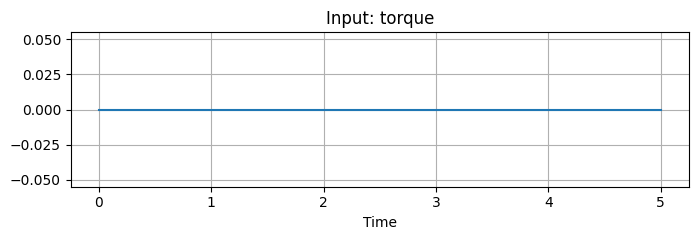

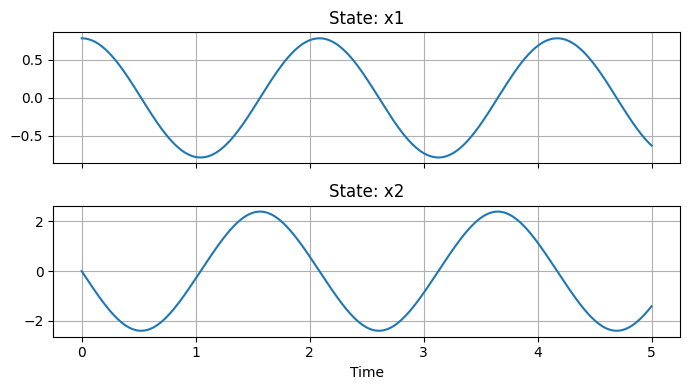

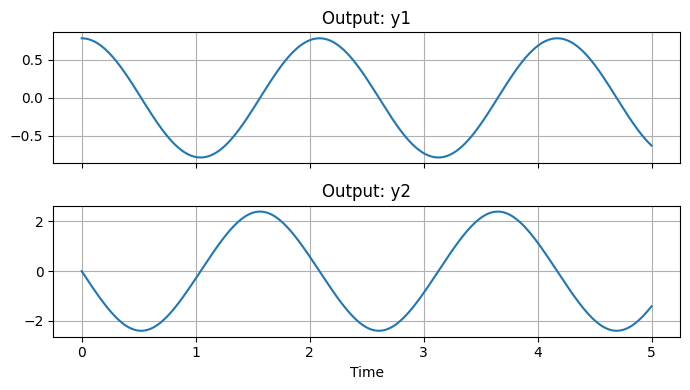

In [7]:
plot_info = {
    "Input": "inputs",
    "State": "states",
    "Output": "outputs",
}

for title, attr_name in plot_info.items():
    data = getattr(result, attr_name)
    fig, axes = make_time_series_plots(data, title_fmt=title + ": {name}")
    plt.tight_layout()
    plt.show()

## Cart and Inverted Pendulum Example

In [22]:
# Define symbolic variables
x = cas.MX.sym("x", 4)  # State: [x, dx, theta, dtheta]
u = cas.MX.sym("u", 1)  # Input: [force]
p = cas.MX.sym("p", 5)  # Parameters: [m, M, L, g, d]

# Extract states
x_pos = x[0]  # Cart position
x_dot = x[1]  # Cart velocity
theta = x[2]  # Pendulum angle
theta_dot = x[3]  # Pendulum angular velocity

# Extract parameters
m = p[0]  # Pendulum mass
M = p[1]  # Cart mass
L = p[2]  # Pendulum length
g = p[3]  # Gravity
d = p[4]  # Damping

# Extract input
force = u[0]

# Cart-pendulum dynamics (symbolic CasADi expressions)
sin_theta = cas.sin(theta)
cos_theta = cas.cos(theta)
mL = m * L
D = 1 / (L * (M + m * (1 - cos_theta**2)))
b = mL * theta_dot**2 * sin_theta - d * x_dot + u

# State derivatives
dx = cas.vertcat(
    x_dot,
    D * (-mL * g * cos_theta * sin_theta + L * b),
    theta_dot,
    D * ((m + M) * g * sin_theta - cos_theta * b),
)

# Create CasADi function
dynamics = cas.Function("cartpole", [x, u, p], [dx])

# Create CasADi integrator
integrator = CasADiIntegrator(
    dynamics, method="cvodes", options={"abstol": 1e-8, "reltol": 1e-6}
)

# Conversion function for CasADi -> NumPy
def casadi_to_numpy(x_cas):
    if hasattr(x_cas, "full"):
        arr = np.array(x_cas.full()).flatten()
    else:
        arr = np.asarray(x_cas)
        if arr.ndim > 0:
            arr = arr.flatten()
    # Return Python scalar for single-element arrays to ensure
    # consistent 1D shapes when stacking
    return arr.item() if arr.ndim == 1 and arr.size == 1 else arr

# Custom output function: return only cart position and pendulum angle
def output_func(t, x, u, p):
    """Extract cart position and pendulum angle from state vector."""
    return cas.vertcat(x[0], x[2])  # [cart_position, pendulum_angle]

# Create simulation engine with custom output function
engine = SimulationEngine(
    integrator=integrator,
    output_func=output_func,
    to_numpy=casadi_to_numpy
)

# Initial condition: cart at origin, pendulum at small angle
x0 = cas.DM(
    [
        0.0,  # cart position
        0.0,  # cart velocity
        np.pi,  # pendulum angle (radians, ~5.7 degrees)
        0.0,  # pendulum angular velocity
    ]
)

# Parameters for inverted pendulum
params = cas.DM(
    [
        1.0,  # m: Pendulum mass
        5.0,  # M: Cart mass
        2.0,  # L: Pendulum length
        -10.0,  # g: Gravity (positive for inverted pendulum)
        1.0,  # d: Damping coefficient
    ]
)

# Configure simulation
config = SimulationConfig(
    t_span=(0.0, 10.0),
    x0=x0,
    inputs={"force": ConstantInput(0.0)},  # No control force
    parameters=params,
    dt=0.01,
)

# Run simulation
result = engine.simulate(config)

In [23]:
import math

def cartpend_dxdt(t, x, m=1, M=5, L=2, g=-10, d=1, u=0):
    """Simulates the non-linear dynamics of a simple cart-pendulum system.
    These non-linear ordinary differential equations (ODEs) return the
    time-derivative at time t given the current state of the system.

    Args:
        t (float): Time variable - not used here but included for
            compatibility with solvers like scipy.integrate.solve_ivp.
        x (np.array): State vector. This should be an array of
            shape (4, ) containing the current state of the system.
            y[0] is the x-position of the cart, y[1] is the velocity
            of the cart (dx/dt), y[2] is the angle of the pendulum
            (theta) from the vertical in radians, and y[3] is the
            rate of change of theta (dtheta/dt).
        m (float): Mass of pendulum.
        M (float): Mass of cart.
        L (float): Length of pendulum.
        g (float): Acceleration due to gravity.
        d (float): Damping coefficient for friction between cart and
            ground.
        u (float): Force on cart in x-direction.

    Returns:
        dx (np.array): The time derivate of the state (dx/dt) as an
            array of shape (4,).
    """

    # Temporary variables
    sin_x = math.sin(x[2])
    cos_x = math.cos(x[2])
    mL = m * L
    D = 1 / (L * (M + m * (1 - cos_x**2)))
    b = mL * x[3]**2 * sin_x - d * x[1] + u
    dx = np.zeros(4)

    # Non-linear ordinary differential equations describing
    # simple cart-pendulum system dynamics
    dx[0] = x[1]
    dx[1] = D * (-mL * g * cos_x * sin_x + L * b)
    dx[2] = x[3]
    dx[3] = D * ((m + M) * g * sin_x - cos_x * b)

    return dx


x = np.array([0.0, 0.0, np.pi + 0.1, 0.0])
t = 0.0
cartpend_dxdt(t, x).round(3)

array([0.   , 0.198, 0.   , 0.598])

In [24]:
x = cas.DM([0.0, 0.0, np.pi + 0.1, 0.0])
u = cas.DM([0.0])
p = cas.DM([1.0, 5.0, 2.0, -10.0, 1.0])
dynamics(x, u, p)

DM([0, 0.198274, 0, 0.597809])

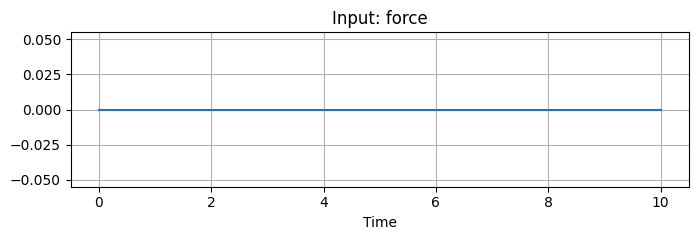

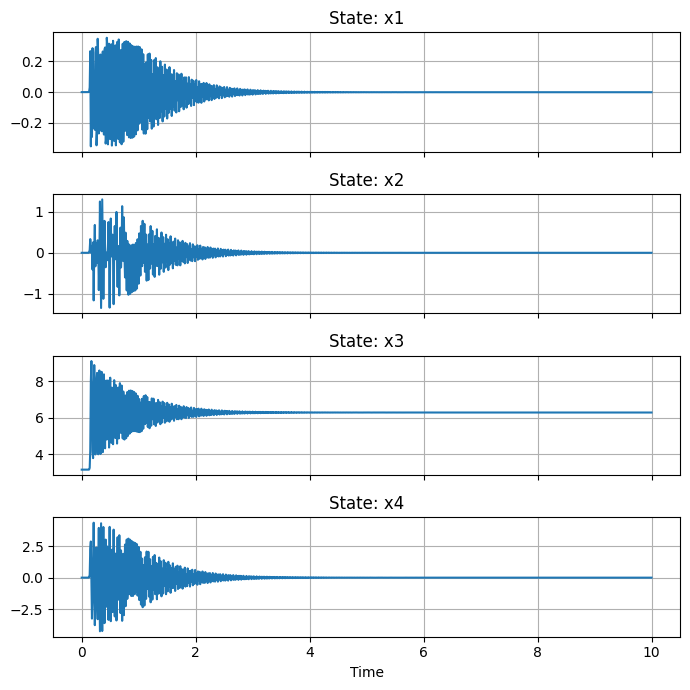

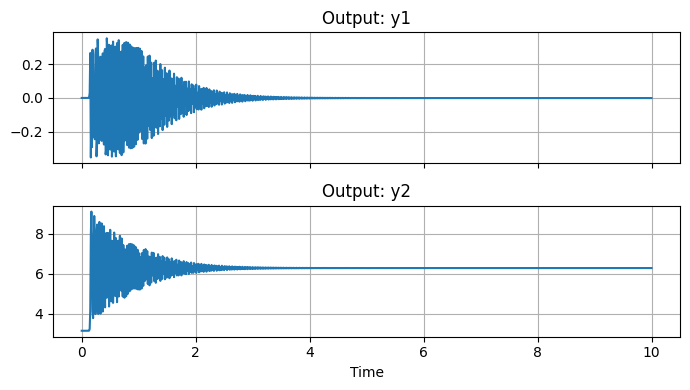

In [25]:
plot_info = {
    "Input": "inputs",
    "State": "states",
    "Output": "outputs",
}

for title, attr_name in plot_info.items():
    data = getattr(result, attr_name)
    fig, axes = make_time_series_plots(data, title_fmt=title + ": {name}")
    plt.tight_layout()
    plt.show()